In [1]:
import torch
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torchvision import transforms
from engine.engine import *
from data.dataloader import *
from utils.data_utils import *
from models.cnn_model import *
from utils.helper_function import *

In [2]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize((32, 32)),  # Resize the images if needed
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),         # Convert images to tensor
    transforms.Normalize(mean=[0.485], std=[0.229])  # Normalize
])


test_transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize the images if needed
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),         # Convert images to tensor
    transforms.Normalize(mean=[0.485], std=[0.229])  # Normalize
])
#Hyperparameter
NUM_EPOCHS = 20
# NUM_WORKERS = os.cpu_count()
LR_RATE = 1e-3
BATCH_SIZE = 64

# Device agnostic
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
input_dir = "/Users/winirrr/Documents/EventBased_Project/datasets/dif_duration_dataset_1/11ms"


train_dataloader, test_dataloader, classes = create_dataloader_v2(data_dir=input_dir,
                                                               train_transform=train_transform,
                                                               test_transform=test_transform,
                                                               batch_size=BATCH_SIZE,
                                                               )

Number of classes: 2
Class to index mapping: {'no_press': 0, 'press': 1}
Total number of images: 23267
Number of training images: 18613
Number of test images: 4654
Training DataLoader:
torch.Size([64, 1, 32, 32]) torch.Size([64])
Test DataLoader:
torch.Size([64, 1, 32, 32]) torch.Size([64])
Number of training batches: 291
Number of test batches: 73


In [4]:
df = create_file_label_dataframe(input_dir)
df.label.value_counts()

label
no_press    13060
press       10207
Name: count, dtype: int64

In [5]:
from timeit import default_timer as timer

model = LeNet()

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=LR_RATE,
                             weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
early_stopping = EarlyStopping(patience=5)

start_time = timer()
model_results = train(model=model,
                      train_dataloader=train_dataloader,
                      test_dataloader=test_dataloader,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=NUM_EPOCHS,
                      device=device,
                      early_stopping=early_stopping,
                      scheduler=scheduler)
end_time = timer()
print(f"Total training time: {end_time - start_time:.3f} secs")

  0%|          | 0/20 [00:00<?, ?it/s]

Epochs: 0 | train_loss : 0.2624 | train_acc: 90.07% | test_loss : 0.0497| test_acc: 98.52%
Epochs: 1 | train_loss : 0.0372 | train_acc: 98.85% | test_loss : 0.0259| test_acc: 99.32%
Epochs: 2 | train_loss : 0.0232 | train_acc: 99.37% | test_loss : 0.0191| test_acc: 99.46%
Epochs: 3 | train_loss : 0.0180 | train_acc: 99.53% | test_loss : 0.0148| test_acc: 99.59%
Epochs: 4 | train_loss : 0.0128 | train_acc: 99.69% | test_loss : 0.0141| test_acc: 99.61%
Epochs: 5 | train_loss : 0.0109 | train_acc: 99.74% | test_loss : 0.0141| test_acc: 99.61%
Epochs: 6 | train_loss : 0.0110 | train_acc: 99.73% | test_loss : 0.0165| test_acc: 99.59%
Epochs: 7 | train_loss : 0.0090 | train_acc: 99.78% | test_loss : 0.0108| test_acc: 99.72%
Epochs: 8 | train_loss : 0.0081 | train_acc: 99.78% | test_loss : 0.0101| test_acc: 99.72%
Epochs: 9 | train_loss : 0.0078 | train_acc: 99.77% | test_loss : 0.0101| test_acc: 99.72%
Epochs: 10 | train_loss : 0.0073 | train_acc: 99.79% | test_loss : 0.0085| test_acc: 99.76

In [6]:
save_model_std(model=model,
               model_name="dv_df_11ms_aug_LeNet_1")

Saving model to: models_save/dv_df_11ms_aug_LeNet_1.pth


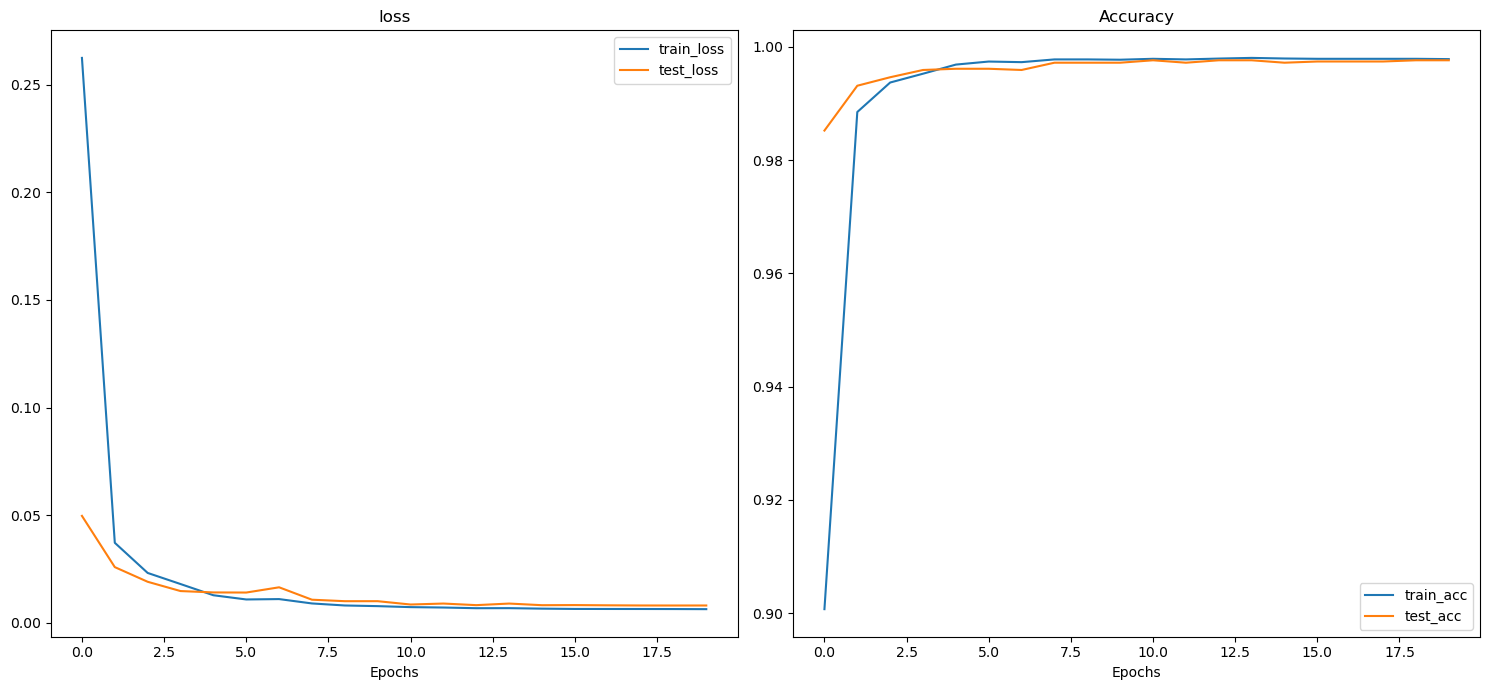

In [7]:
plot_loss_curves(model_results)

In [8]:
results_dir = "/Users/winirrr/Documents/EventBased_Project/results"
os.makedirs(os.path.join(results_dir,"exp_10"), exist_ok=True)
result_dir = os.path.join(results_dir,"exp_10")

df = pd.DataFrame(model_results)
df.to_csv(os.path.join(result_dir,"dv_df_11ms.csv"))